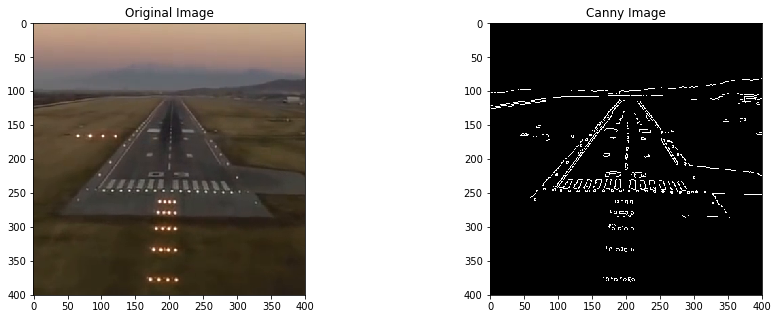

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import convolve
from scipy import ndimage

def plotImages(name, image, n_subplot):
    plt.subplot(n_subplot)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    
original_image = cv2.imread('../Images/Cropped_Runway_Images/00104.png')
cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
edges_image = cv2.Canny(original_image, 50, 100)
plt.figure(figsize=(15,5))
plotImages('Original Image',original_image, 121)
plotImages('Canny Image',edges_image, 122)
plt.show()

(7, 7)


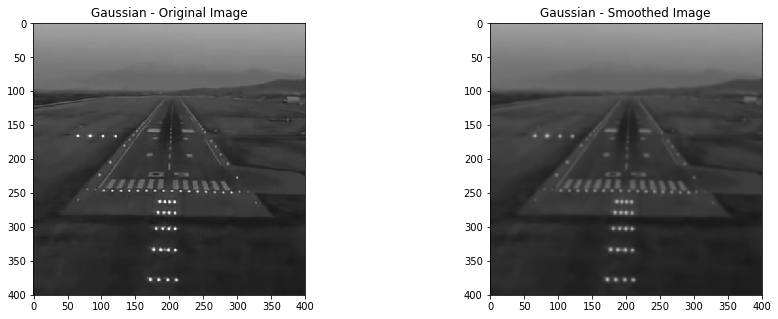

In [2]:
def gaussian_Smoothing(kernel_size, sigma):
    kernel_size = int(kernel_size) // 2
    x,y = np.mgrid[-kernel_size:kernel_size+1,-kernel_size:kernel_size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gaussian = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    print(gaussian.shape)
    return gaussian

test_original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
test_smoothed_image = convolve(test_original_image, gaussian_Smoothing(7, sigma=1.4))
    
plt.figure(figsize=(15,5))
plotImages('Gaussian - Original Image',test_original_image, 121)
plotImages('Gaussian - Smoothed Image',test_smoothed_image, 122)
plt.show()
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(7, 7)


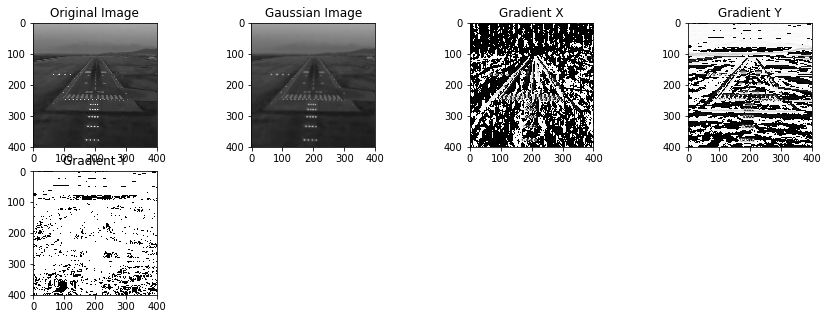

In [3]:
def Sobel_Gradient_X_Y(image):
    G_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)
    G_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)
    I_x = ndimage.filters.convolve(image, G_x)
    I_y = ndimage.filters.convolve(image, G_y)
    return I_x,I_y

def gradient_Magnitude(I_x,I_y):
    magnitude = np.hypot(I_x,I_y) # sqrt(x*x + y*y)
    magnitude *= 255.0 / np.max(magnitude)
    return np.array(magnitude)

def orientation_Edge(I_x,I_y):
    angle_theta = np.arctan2(I_y,I_x)
    return (gradient, angle_theta)

plt.figure(figsize=(15,5))
#1
ntest_original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
plotImages('Original Image',ntest_original_image, 241)
#2
ntest_smoothed_image = convolve(ntest_original_image, gaussian_Smoothing(7, sigma=1.4))
plotImages('Gaussian Image',ntest_smoothed_image, 242)
#3
gradient_X, gradient_Y = Sobel_Gradient_X_Y(ntest_smoothed_image)
plt.subplot(243)
plt.imshow(cv2.cvtColor(gradient_X,cv2.COLOR_GRAY2RGB))
plt.title("Gradient X")
plt.subplot(244)
plt.imshow(cv2.cvtColor(gradient_Y,cv2.COLOR_GRAY2RGB))
plt.title("Gradient Y")
#4
magnitude = gradient_Magnitude(gradient_X,gradient_Y)
plt.subplot(245)
plt.imshow(cv2.cvtColor(np.float32(magnitude),cv2.COLOR_RGB2BGR))
plt.title("Gradient Y")  

plt.show()

In [4]:
def non_Maximum_Suppression(image, d_angle):
    rows, cols = image.shape
    new_image = np.zeros((rows,cols), dtype=np.int32)
    angle = d_angle * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            try:
                q = r = 255
                #angle 0
                if(0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image[i,j+1]
                    r = image[i,j-1]
                #angle 45
                elif(22.5 <= angle[i,j] < 67.5):
                    q = image[i+1,j-1]
                    r = image[i-1,j+1]
                #angle 90
                elif(67.5 <= angle[i,j] < 112.5):
                    q = image[i+1,j]
                    r = image[i-1,j]
                #angle 135
                elif(112.5 <= angle[i,j] < 157.5):
                    q = image[i-1,j-1]
                    r = image[i+1,j+1]
                if(image[i,j] >= q) and (image[i,j] >= r):
                    new_image[i,j] = image[i,j]
                else:
                    new_image[i,j] = 0
            except IndexError as e:
                pass
    return new_image
    
    
def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = image.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    rows, cols = image.shape
    tmp = np.zeros((rows,cols), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    strong_i, strong_j = np.where(image >= highThreshold)
    zeros_i, zeros_j = np.where(image < lowThreshold)
    weak_i, weak_j = np.where((image <= highThreshold) & (image >= lowThreshold))
    tmp[strong_i, strong_j] = strong
    tmp[weak_i, weak_j] = weak
    return (tmp, weak, strong)    
    
def hysteresis(img, weak, strong=255):
    rows, cols = img.shape  
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img    


In [ ]:
def CannyEdgeDetector(original_image):
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    smoothed_image = convolve(original_image, gaussian_Smoothing(7, sigma=1.4))
    gradient, angle = Sobel_Edge_Detector(smoothed_image)
    image_NMS = non_Maximum_Suppression(gradient, angle)
    img_threshold, weak, strong = threshold(image_NMS, lowThresholdRatio=0.07, highThresholdRatio=0.19)
    result = hysteresis(img_threshold, weak, strong=strong)
    
    plt.figure(figsize=(15,5))
    plotImages('Original',original_image, 121)
    plotImages('Result',np.float32(result), 122)
    plt.show()
    
    
CannyEdgeDetector(original_image)